# Machine Learning & AI - Credit Card Fraud

**Portfolio Project**

Showcasing the cleansing, transformation and use of data to predict credit card fraud using machine learning.

**Brief**

Every year billions of pounds are lost to credit card fraud. While fraud is a substantial cost to the financial system, so too is the cost of detecting credit card fraud. In a competitive market, banks need to balance the cost of fraud against the impact on customer experience of onerous controls. In other words, false positives in the fraud detection process can lead to customer transactions being erroneously declined. This highlights the need for effective detection systems with low rates of error.

Task is to analyse a set of transactions, develop the respective feature inputs and create an appropriate, scalable model for predicting potential fraudulent transactions.


# **Task 1 - Data Import and Exploration**

In [ ]:
# Import File
from google.colab import files
uploaded = files.upload()

Saving CreditCardDataFinal.csv to CreditCardDataFinal.csv


## **Data Exploration**


Exploring the data provides the developer with a baselevel understanding of the data structure, format, and contents. Fixing data quality issues in the beginning of the process increases the overall efficiency and quality of the program by reducing the chance of ‘Garbage in, garbage out’. (Nithya Sambasivan, 2021)

In [ ]:
# Import the all libraries that are used:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# 100,000 card transactions* – recorded on 13th and 14th October 2020
# Load the dataset into a Dataframe
df = pd.read_csv('CreditCardDataFinal.csv')

# Display number of rows and columns
df.shape

(100000, 16)

In [ ]:
# Display first 5 rows to verify correct import of data and columns
df.head(5)

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,#3577 209,14-Oct-20,Wednesday,19,Visa,Tap,£5,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25.2,RBS,0
1,#3039 221,14-Oct-20,Wednesday,17,MasterCard,PIN,£288,POS,Services,USA,USA,USA,F,49.6,Lloyds,0
2,#2694 780,14-Oct-20,Wednesday,14,Visa,Tap,£5,POS,Restaurant,India,India,India,F,42.2,Barclays,0
3,#2640 960,13-Oct-20,Tuesday,14,Visa,Tap,£28,POS,Entertainment,United Kingdom,India,United Kingdom,F,51.0,Barclays,0
4,#2771 031,13-Oct-20,Tuesday,23,Visa,CVC,£91,Online,Electronics,USA,USA,United Kingdom,M,38.0,Halifax,1


In [ ]:
# More detailed look at the data frame as a whole
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Transaction ID          100000 non-null  object 
 1   Date                    100000 non-null  object 
 2   Day of Week             100000 non-null  object 
 3   Time                    100000 non-null  int64  
 4   Type of Card            100000 non-null  object 
 5   Entry Mode              100000 non-null  object 
 6   Amount                  99994 non-null   object 
 7   Type of Transaction     100000 non-null  object 
 8   Merchant Group          99990 non-null   object 
 9   Country of Transaction  100000 non-null  object 
 10  Shipping Address        99995 non-null   object 
 11  Country of Residence    100000 non-null  object 
 12  Gender                  99996 non-null   object 
 13  Age                     100000 non-null  float64
 14  Bank                 

Updating data formats at this stage, allows for the use of means to fill in blank/ missing values for numeric fields.

In [ ]:
# Replacing symbols from numeric values and setting numeric and time data type
# remove the '£' symbol from the values
df['Amount'] = df['Amount'].str.replace('£', '')

# Convert the "Amount" column to int, handling errors as 'coerce' to replace non-numeric values with NaN
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce').astype('Int32')


# remove space and # from transaction id
df['Transaction ID'] = df['Transaction ID'].str.replace(' ', '')
df['Transaction ID'] = df['Transaction ID'].str.replace('#', '')
# Convert the "Transaction ID" column to int, handling errors as 'coerce' to replace non-numeric values with NaN
df['Transaction ID'] = pd.to_numeric(df['Transaction ID'], errors='coerce').astype('Int64')

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# **Task 2 - Data Processing**

## 2a - Duplicates

Duplicates have the potential to contaminate the data with errant or inconsistent record which can harm confuse the model later on, this makes it vital to ensure that all rows are unique (Chorev, 2021).

I've addressed potential duplicates in the dataset by using the "duplicated" function to identify and display duplicate rows. If any are found, they're removed. This ensures the model uses high-quality data. However, if there are many duplicates, this may reduce the dataset size, potentially impacting training data quantity.

In [ ]:
# Check for duplicate rows in the DataFrame
duplicate_rows = df[df.duplicated()]
print(f"Duplicate rows: {duplicate_rows.shape[0]}")

# Incase duplicates rows are found drop them
if not duplicate_rows.empty:
    display(duplicate_rows)
    df.drop_duplicates(inplace=True)
    print("\nDuplicate rows removed!")


Duplicate rows: 0


## 2b - Missing Values

Null or missing data can pose challenges for many machine learning algorithms, potentially leading to unexpected outcomes such as skewing calculations like averages.


In [ ]:
# Check for missing values in each column
nan_columns = df.columns[df.isna().any()].tolist()

# Print columns with missing values and the number of missing values
if len(nan_columns) ==  0 :
  print("\nNo columns with missing values")

else:
  print("\nMissing Values by Column:")
  for col in nan_columns:
      nan_count = df[col].isna().sum()
      print(f"{nan_count} Missing values in '{col}'.")


Missing Values by Column:
6 Missing values in 'Amount'.
10 Missing values in 'Merchant Group'.
5 Missing values in 'Shipping Address'.
4 Missing values in 'Gender'.


### Dealing with Missing Values

1.	For numeric fields using the average (mean) value- this approach minimises the impact of outliers and ensures that the overall structure of the data
2.	Row deletion – this approach presents the original distribution of the data as there is no guess work involved especially when the values are categorical with many different answers. This approach does have quite a big downside depending on the amount of data being deleted as it could lead to significant loss of information.
3.	 Forward Filling: this approach uses the last value to fill in the missing value, this approach in case of gender has a 50% chance of being correct however it is best suited for sequential or timeseries data. As there are only 4 missing values identified for gender, the impact is minimal.


In [ ]:
# Fill amount and age missing values with mean
df['Amount'].fillna(int(df['Amount'].mean()), inplace=True)
df['Age'] = df['Age'].fillna(df['Age'].mean())

# Drop rows where 'Merchant Group' or 'Shipping Address' ia missing
df = df.dropna(subset=['Merchant Group','Shipping Address'])

# Forward fill the gender column with forward fill
df['Gender'].fillna(method='ffill', inplace=True)

<ipython-input-9-d732c567325b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gender'].fillna(method='ffill', inplace=True)


In [ ]:
# recheck for missing values in each column
nan_columns = df.columns[df.isna().any()].tolist()

# Print columns with missing values and the number of missing values
if len(nan_columns) ==  0 :
  print("\nNo columns with missing values")

else:
  print("\nMissing Values by Column:")
  for col in nan_columns:
      nan_count = df[col].isna().sum()
      print(f"{nan_count} Missing values in '{col}'.")


No columns with missing values


In [ ]:
# Number of rows and columns in data frame after dealing with missing values - 15 rows dropped so expected 99,985 rows
df.shape

(99985, 16)

## 2c - Outliers

Outliers have the potential to skew the data impacting the over accuracy of the model. To limit the impact of outliers, an exploratory approach is used where numeric values are presented in box plots clearly showing the bounds and the distribution of the data. For categorical fields, we look to see if there are any values out of our expectations.

Visuals used are packed in methods as they are used multiple times, one to check the original data and then again to chekc the cleansed data.

Observations: Amount - We can see a heavy positive skew (skewed right) in the data. This means most of the transactions are low amounts. We can see this in the box plot.

Age - Age below 18 are not expected as 18 is the minimum age for someone to get a credit card in the UK (Post Office, 2023). Though the top whisker doesn't include the max value of 86.1, this value is in line with expectations.

Time - Max value of 24 is unexpected due to 12am being read as 00:00. Most transactions occur during the day between 10:00 and 19:00, this is to be expected as post people tend to spend during the day.

Date - Transactions on 15/10 and 16/10 are unexpected.

Day of Week - This should only be Tuesday or Wednesday as those are the days on 13/10 and 14/10

Bank - Spelling error on Barclays, some entries spelt as Barlcays


In [ ]:
# Create method for numeric field exploration
def plot_numeric_fields(df):
    # Using box plots on numeric fields to find amount of value spread
    plt.figure(figsize=(12, 3))

    # Amount
    plt.subplot(1, 3, 1)
    plt.boxplot(df['Amount'])
    plt.title('Box Plot for Amount')
    plt.text(1, df['Amount'].max(), f'Max: {df["Amount"].max()}', verticalalignment='bottom', horizontalalignment='left',
             color='green', fontsize=12)
    plt.text(1, df['Amount'].min(), f'Min: {df["Amount"].min()}', verticalalignment='top', horizontalalignment='left',
             color='red', fontsize=12)

    # Age
    plt.subplot(1, 3, 2)
    plt.boxplot(df['Age'])
    plt.title('Box Plot for Age')
    plt.text(1, df['Age'].max(), f'Max: {df["Age"].max()}', verticalalignment='bottom', horizontalalignment='left',
             color='green', fontsize=12)
    plt.text(1, df['Age'].min(), f'Min: {df["Age"].min()}', verticalalignment='top', horizontalalignment='left',
             color='red', fontsize=12)

    # Time
    plt.subplot(1, 3, 3)
    plt.boxplot(df['Time'])
    plt.title('Box Plot for Time')
    plt.text(1, df['Time'].max(), f'Max: {df["Time"].max()}', verticalalignment='bottom', horizontalalignment='left',
             color='green', fontsize=12)
    plt.text(1, df['Time'].min(), f'Min: {df["Time"].min()}', verticalalignment='top', horizontalalignment='left',
             color='red', fontsize=12)

    # Show the box plots
    plt.show()

In [ ]:
# Create method for categorical field exploration
def plot_categorical_data(df, categorical_columns):
    # Create bar charts for categorical columns
    plt.figure(figsize=(15,10))
    for i, column in enumerate(categorical_columns, 1):
        plt.subplot(3, 4, i)
        counts = df[column].value_counts()
        counts.plot(kind='bar')
        plt.xlabel(column)
        plt.ylabel('Count')

        # Add data labels showing the count above each bar
        for index, count in enumerate(counts):
            plt.text(index, count, str(count), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()

    # Show the bar charts
    plt.show()

Numeric Columns


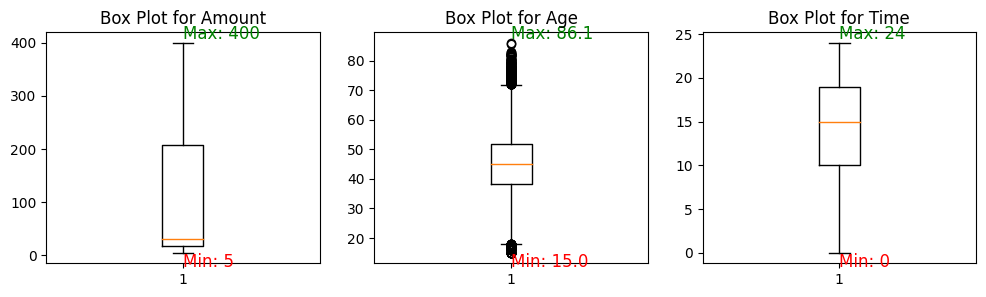



Categoric Columns


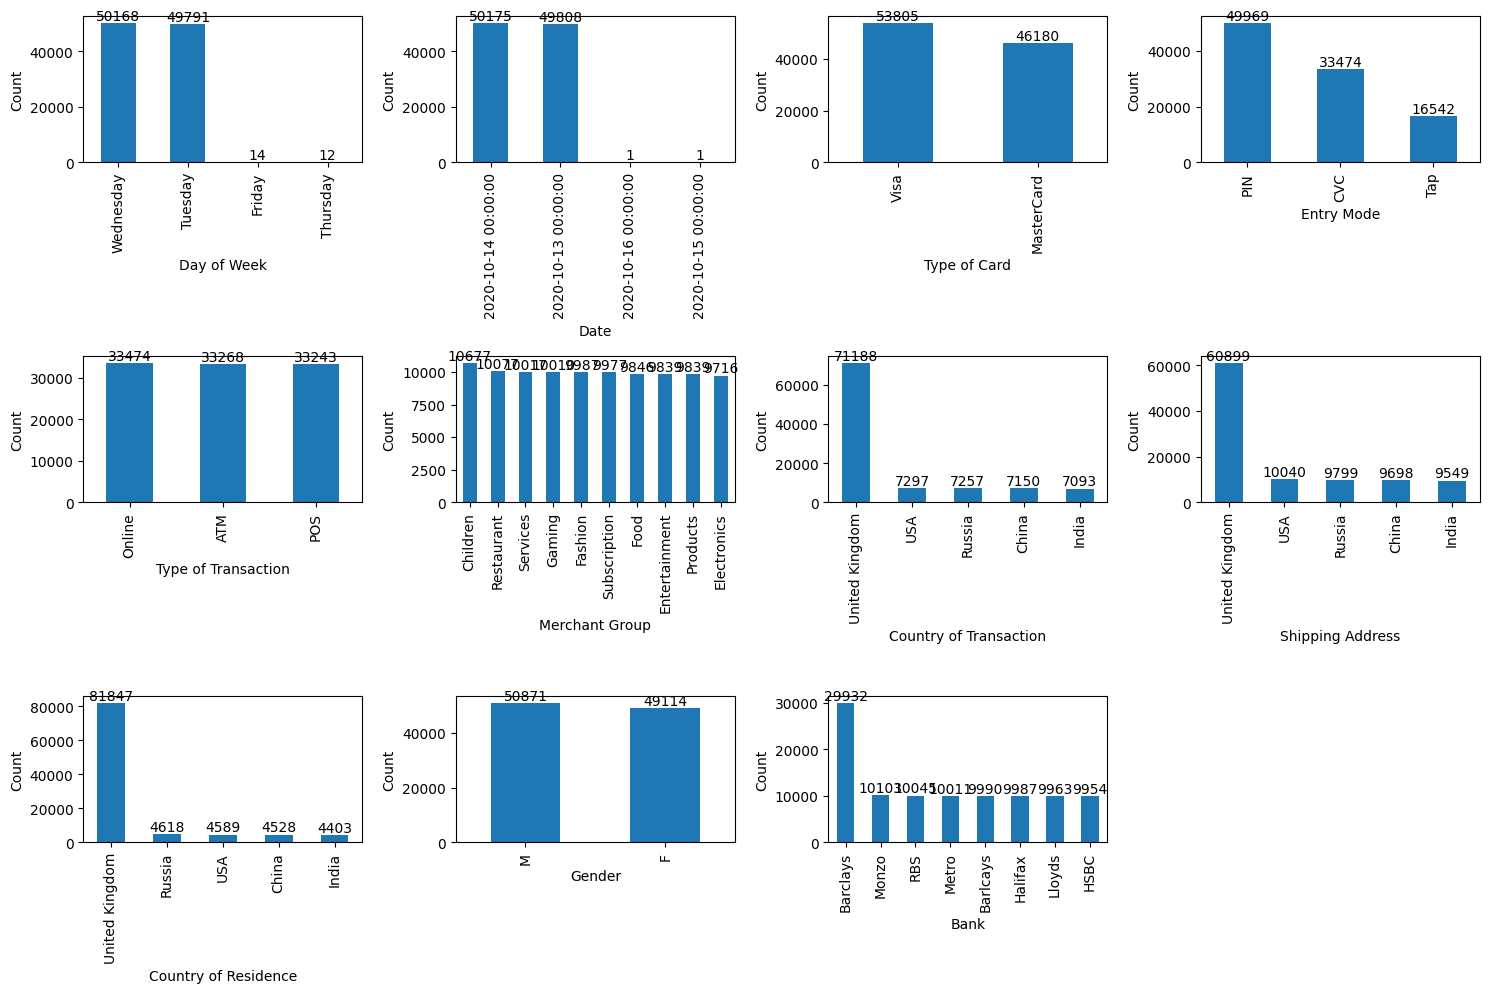

In [ ]:
#define categorical columns
categorical_columns = ['Day of Week', 'Date','Type of Card', 'Entry Mode', 'Type of Transaction', 'Merchant Group', 'Country of Transaction', 'Shipping Address', 'Country of Residence', 'Gender', 'Bank']

#Explore field with visuals
print("Numeric Columns")
plot_numeric_fields(df)
print("\n\nCategoric Columns")
plot_categorical_data(df, categorical_columns)

### Dealing with Outliers

Most of the outliers were a result of data not matching the data description, these are filtered out of the data so they don't skew the analysis.

Where an error has been spotted, it has been fixed by replacing the correct value in please.


In [ ]:
# Replace '24' with '0' in the 'Time' column
df['Time'] = df['Time'].replace(24, 0)

# Filter age <18
df = df[df['Age'] >= 18]

In [ ]:
# Filter rows for only 13/10/2020 and 14/10/2020
valid_dates = ['2020-10-13', '2020-10-14']
df = df[df['Date'].dt.strftime('%Y-%m-%d').isin(valid_dates)]

# Check and correct day of week
for index, row in df.iterrows():
   expected_day = row['Date'].strftime('%A')
   if row['Day of Week'] != expected_day:
    df = df.drop(index)

# Fixing the Barlcays spelling error
df = df.replace(to_replace="Barlcays", value="Barclays")

Numeric Columns


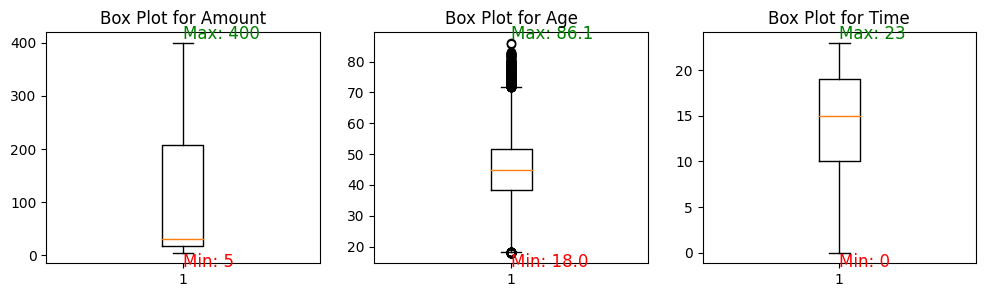



Categoric Columns


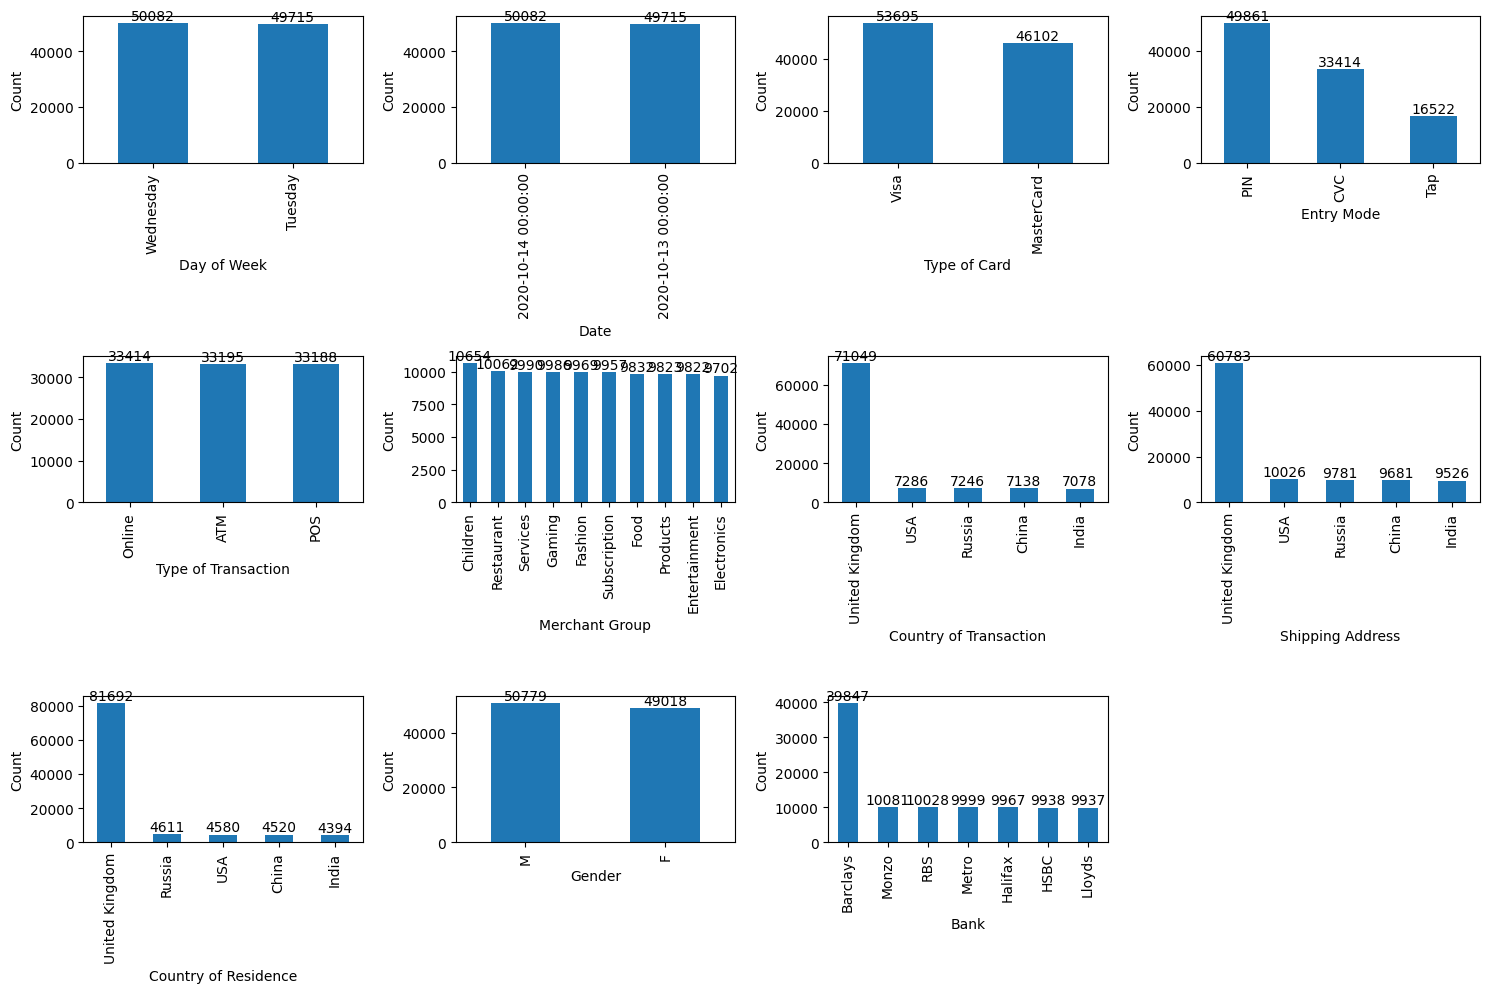

In [ ]:
#Explore corrected field with visuals to verify
print("Numeric Columns")
plot_numeric_fields(df)
print("\n\nCategoric Columns")
plot_categorical_data(df, categorical_columns)

In [ ]:
# Number of rows and columns in data frame after dealing with outliers
df.shape

(99797, 16)

# **Task 3 - Transformation**

## 3a - Formatting

Formatting columns into the correct data type was first done when the data was imported as a part of Data Exploration and has been updated throughout up til this point if required.

## 3b - Feature Engineering

Feature engineering the processing of adding or modifying existing features to enhance the raw data set with additional dimensions (Dong & Liu, 2018).

In this model, I've incorporated tags for cases where the residence country differs from both the shipping and transaction countries, or if the shipping country differs from the transaction country. This distinction proves valuable in detecting potential credit card fraud. When all three countries are distinct, it raises a stronger suspicion of fraudulent activity.

Another addition is categorising cardholders by age range instead of individual ages. This approach allows us to assess potential susceptibility to fraud in broader groups, smoothing out any uneven distributions.

Due to the addition of the above fields, Age and country related filed have been removed, additionally transaction ID is removed as it is a key field with no valuable insight. Gender has been removed as there is potential for data bias to be adopted into the model.


In [ ]:
# i. Add flag Boolean for if country of residence is different to shipping address or if it's different to country of transaction
df['Residence_Shipping_Diff'] = (df['Country of Residence'] != df['Shipping Address']).astype(int)
df['Residence_Transaction_Diff'] = (df['Country of Residence'] != df['Country of Transaction']).astype(int)
df['Shipping_Transaction_Diff'] = (df['Shipping Address'] != df['Country of Transaction']).astype(int)

In [ ]:
# ii. Add age group <18, 18-25, 26-35, 36-45, 46-55, 56-65, 66-75, 75+ and remove the age column
bins = [0, 18, 25, 35, 45, 55, 65, 75, 100]
labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '75+']

df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

In [ ]:
#Age, Transaction ID and Gender can be dropped from the table as they are not required for the analysis
df = df.drop(['Age', 'Transaction ID', 'Gender','Country of Transaction', 'Shipping Address', 'Country of Residence'], axis=1)

# Now the DataFrame 'df' has the additional engineered features
df.head(5)

,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Bank,Fraud,Residence_Shipping_Diff,Residence_Transaction_Diff,Shipping_Transaction_Diff,Age Group
0,2020-10-14,Wednesday,19,Visa,Tap,5,POS,Entertainment,RBS,0,0,0,0,26-35
1,2020-10-14,Wednesday,17,MasterCard,PIN,288,POS,Services,Lloyds,0,0,0,0,46-55
2,2020-10-14,Wednesday,14,Visa,Tap,5,POS,Restaurant,Barclays,0,0,0,0,36-45
3,2020-10-13,Tuesday,14,Visa,Tap,28,POS,Entertainment,Barclays,0,1,0,1,46-55
4,2020-10-13,Tuesday,23,Visa,CVC,91,Online,Electronics,Halifax,1,1,1,0,36-45


## 3c - Encoding Category Variables


Label encoding involves assigning numerical values to categorical fields, enabling them to be used by algorithms that only accept numeric inputs. Unlike techniques like one-hot encoding, label encoding doesn't introduce additional fields, making it more memory efficient.

In [ ]:
# Tag cetegorical columns from remaining columns
categorical_columns = ['Date', 'Day of Week', 'Type of Card', 'Entry Mode', 'Type of Transaction', 'Merchant Group', 'Bank', 'Age Group']
# Create a LabelEncoder instance for encoding categorical variables
label_encoder = LabelEncoder()

for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [ ]:
# Check all categorical columns are correctly encoded
df.head(5)

,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Bank,Fraud,Residence_Shipping_Diff,Residence_Transaction_Diff,Shipping_Transaction_Diff,Age Group
0,1,1,19,1,2,5,2,2,6,0,0,0,0,1
1,1,1,17,0,1,288,2,8,3,0,0,0,0,3
2,1,1,14,1,2,5,2,7,0,0,0,0,0,2
3,0,0,14,1,2,28,2,2,0,0,1,0,1,3
4,0,0,23,1,0,91,1,1,2,1,1,1,0,2


## 3d - Normalisation

Values tend to be spread out and with large differences in their ranges, min and max values and general distribution. Normalisation rescales the values to bring them closer together, this is because many algorithms are sensitive to scale with large variances likely to skew the output (Mohamed & Schuller, n.d.).

MinMax normalisation scales all values on a scale from 0-1 minimising the impact large values. This type of normalisation keeps the distribution and skew of the original data which can still have a negative impact on the model. In case of the Amounts, they are skewed to the right with the majority of transactions being small but having a few very large transactions. Using the Box-cox normalisation method can help stabilise the variance by plotting it on a normal distribution and minimising the impact of the larger values (Atkinson, 2020). If there is a version 2 of this tool, this should be explored further to improve the model accuracy.


In [ ]:
# List of columns to normalise (excluding target column and columns already with values between 0,1)
normalise_columns = ['Time', 'Entry Mode', 'Amount', 'Type of Transaction', 'Merchant Group', 'Bank', 'Age Group']

scaler = MinMaxScaler()

df[normalise_columns] = scaler.fit_transform(df[normalise_columns])

In [ ]:
df.head(5)

,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Bank,Fraud,Residence_Shipping_Diff,Residence_Transaction_Diff,Shipping_Transaction_Diff,Age Group
0,1,1,0.826087,1,1.0,0.000000,1.0,0.222222,1.000000,0,0,0,0,0.166667
1,1,1,0.739130,0,0.5,0.716456,1.0,0.888889,0.500000,0,0,0,0,0.500000
2,1,1,0.608696,1,1.0,0.000000,1.0,0.777778,0.000000,0,0,0,0,0.333333
3,0,0,0.608696,1,1.0,0.058228,1.0,0.222222,0.000000,0,1,0,1,0.500000
4,0,0,1.000000,1,0.0,0.217722,0.5,0.111111,0.333333,1,1,1,0,0.333333


## 3e - Splitting Data

Splitting the data into training and test data allows for a good baseline when comparing multiple models to find the most appropriate one. An 80/20 training and test split has been used to provide a large amount of training data while retaining enough data to test key parameters of the model.

In [ ]:
# Assign values to X and Y
X,y = df.drop('Fraud',axis=1), df['Fraud']

# Split the data into a training set (e.g., 80% of the data) and a testing set (e.g., 20% of the data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
print('Training data shape:\n', y_train.value_counts())
print('\n{:,.5}%'.format(y_train.sum()/len(y_train)*100),'Fraud')
print('\n\nTesting data shape:\n', y_test.value_counts())
print('\n{:,.5}%'.format(y_test.sum()/len(y_test)*100),'Fraud')
#print('Train data shape: ',X_train.shape,'\nNumber of Fraud instances in Training Set:', y_train.sum(), 'which is','{:,.5}%'.format(y_train.sum()/len(y_train)*100)','\nTest data shape: ', X_test.shape)

Training data shape:
 0    74082
1     5755
Name: Fraud, dtype: int64

7.2084% Fraud


Testing data shape:
 0    18535
1     1425
Name: Fraud, dtype: int64

7.1393% Fraud


## 3f - Rebalancing Training Data

Rebalancing help to even out the distribution of the dataset. Imbalanced datasets lead to biasness to one side and perform poorly for the minority class. Synthetic Minority Over-sampling Technique (SMOTE) generates samples for the minority class creating a more balanced distribution (LAVALLE, et al., 2023). Our data is very unbalanced with roughly 7% of the data marked as fraud, this has the potential to heavily skew any model we use without rebalancing towards not fraud. It is important to remember that over and under sampling can both negatively impact on the overall quality of the data so it should be done based on the needs of the dataset.

In [ ]:
# Apply SMOTE to balance the data
smote = SMOTE(random_state=13)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Create a new DataFrame with the resampled data
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='Fraud')], axis=1)

In [ ]:
df_resampled['Fraud'].value_counts()

0    74082
1    74082
Name: Fraud, dtype: int64

# **Task 4 - Train, Make Prediction and Evaluate Two Baseline Models**



Precision: Measures the accuracy of positive predictions (correctly identified fraud cases) among all predicted positives (predicted fraud cases). A high precision indicates a low false positive rate.

Recall: It measures the accuracy of positive predictions among all actual positives (actual fraud). High recall implies a low false negative rate, indicating effective detection.

Precision vs. Recall: A model with low recall but high precision may miss some true fraud cases. On the other hand, a model with high recall but low precision might produce more false alarms.

Precision is often more critical than recall when looking at credit card fraud. Balancing both is important, as a high number of false alarms could lead to customer complaints and additional costs for manual review.

F1 Score: It provides a single metric that balances precision and recall. A score of 1 indicates a perfect model, while 0 implies performance no better than random guessing.

As F1 score is the balance of both precision and recall, having high F1 score is crucial when looking at credit card fraud. Detecting as many fraudulent transactions as possible while having minimal false alarm rates.

Optimal Performance in Credit Card Fraud Detection: It's crucial to aim for both high recall (detecting as many fraudulent transactions as possible) and high precision (minimising false alarms and customer complaints) (Thapa, 2020).



## 4a - Simple Naïve Model - Dummy Classifier

Dummy Classifier is a naïve model which is used to set a baseline to evaluate other models against rather than acting as an accurate model itself. Using the ‘most frequent’ strategy predicts the most common class label (Diemert, et al., 2018). In the case of our data, it marks all test rows as not fraud.

Dummy Classifier
Accuracy: 92.86%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%


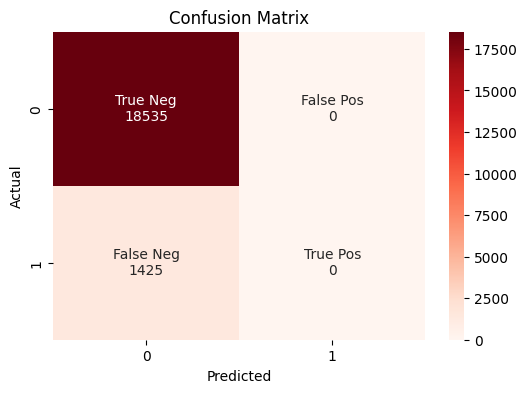

In [ ]:
# Apply the dummy classifier to base model
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)

# Create predictions
y_pred_dc = dummy_classifier.predict(X_test)

# Calculate dummy accuracy
accuracy_dc = accuracy_score(y_test, y_pred_dc) *100
precision_dc = precision_score(y_test, y_pred_dc, zero_division=0) *100
recall_dc = recall_score(y_test, y_pred_dc)*100
f1_dc = f1_score(y_test, y_pred_dc, zero_division=0) * 100

# Print key values
print("Dummy Classifier")
print(f"Accuracy: {accuracy_dc:.2f}%")
print(f"Precision: {precision_dc:.2f}%")
print(f"Recall: {recall_dc:.2f}%")
print(f"F1-Score: {f1_dc:.2f}%")

# Create a confusion matrix
cm_dc=confusion_matrix(y_test, y_pred_dc)
plt.figure(figsize=(6, 4))
group_name = ['True Neg', 'False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm_dc.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_name,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_dc, annot=labels, fmt='', cmap='Reds')

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


By always predicting not fraud, the model is right nearly 93% of the time, the confusion matrix confirms to us that the model did not predict fraud for any of the transactions; as such, it does not have a Precision, Recall or F1 score. As this is the baseline, all other models should match the DC in accuracy as a bare minimum to be considered useful.

## 4b - Logistic Regression

Logistic regression is a statistical model which is primarily used for binary classification (yes/no, 1/0) and is flexible enough to deal with non-normally distributed datasets (Sperandei, 2013). Its is fast to execute and easier to understand compared to other models such as neural networks, it is more interpretable. On the downside, it is sensitive to outliers in data and doesn’t deal with missing data well. This further reiterates the importance of proper data cleansing and pre-processing.

Logistic Regression
Accuracy: 92.26%
Precision: 47.90%
Recall: 95.23%
F1-Score: 63.74%


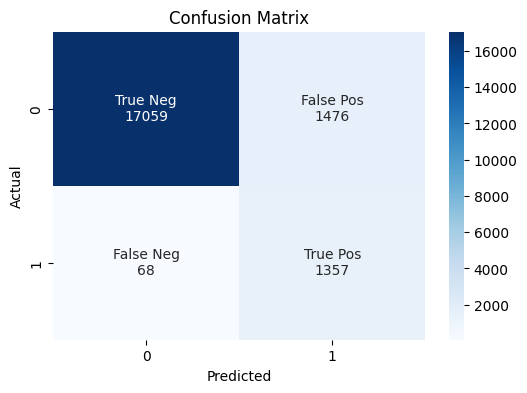

In [ ]:
# Create and train a Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000 , random_state=13)
logistic_model.fit(X_resampled, y_resampled)


# Make predictions on the testing set
y_log_pred = logistic_model.predict(X_test)

accuracy_log = accuracy_score(y_test, y_log_pred) * 100
recall_log = recall_score(y_test, y_log_pred) * 100
precision_log = precision_score(y_test, y_log_pred) * 100
f1_log = f1_score(y_test, y_log_pred) * 100

# Display the results
print("Logistic Regression")
print(f"Accuracy: {accuracy_log:.2f}%")
print(f"Precision: {precision_log:.2f}%")
print(f"Recall: {recall_log:.2f}%")
print(f"F1-Score: {f1_log:.2f}%")

# Create a confusion matrix
cm_log=confusion_matrix(y_test, y_log_pred)

plt.figure(figsize=(6, 4))
group_name = ['True Neg', 'False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm_log.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_name,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_log, annot=labels, fmt='', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


When comparing to the DC, logistic regression is very slightly less accurate, however as this model is predicting positives for fraud it has the key parameter values, we are looking. It has a high recall of 95% which makes this model great for predicting fraud as it has a low false negative rate; this however this in stark contrast to the precision which at 48% meaning this model generates a lot of false positives, flagging many legitimate transactions as fraud; this is likely to dissatisfy the customers. This drops the F1 score to 64% which means right over half the time but still very inaccurate in its predictions.

# **Task 5 - Train, Make Prediction and Evaluate One Supervised Machine Learning Model**


The Random Forest Classifier, an ensemble learning method, combines multiple decision trees for enhanced predictive accuracy in both classification and regression tasks. It excels in high-dimensional data and large datasets, mitigating overfitting through its ensemble nature (SJ Rigatti, 2017). Additionally, it provides feature importance scores for insights .

- Advantages:
  - High predictive accuracy.
  - Handles high-dimensional data and large datasets.
  - Provides feature importance scores.

- Disadvantages:
  - Reduced interpretability compared to a single decision tree and compared to logictic regression.
  - Sensitive to noisy or irrelevant features requireing further scaling or refining .


Random Forest
Accuracy: 97.69%
Precision: 83.79%
Recall: 83.79%
F1-Score: 83.79%


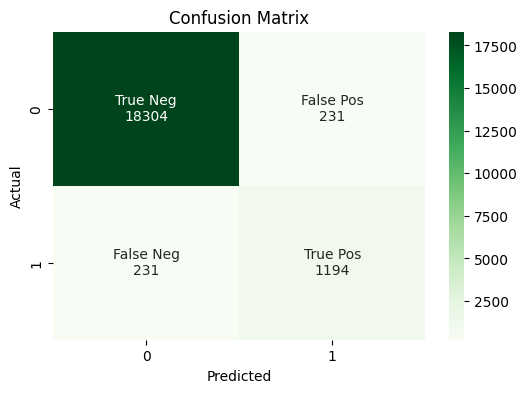

In [ ]:
# Create and train a Random Forest Classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=13)
random_forest_model.fit(X_resampled, y_resampled)

# Make predictions on the testing set
y_pred_rf = random_forest_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf) * 100
recall_rf = recall_score(y_test, y_pred_rf) * 100
precision_rf = precision_score(y_test, y_pred_rf) * 100
f1_rf = f1_score(y_test, y_pred_rf) * 100

# Display the results
print("Random Forest")
print(f"Accuracy: {accuracy_rf:.2f}%")
print(f"Precision: {precision_rf:.2f}%")
print(f"Recall: {recall_rf:.2f}%")
print(f"F1-Score: {f1_rf:.2f}%")

# Create a confusion matrix
cm_rf=confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
group_name = ['True Neg', 'False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm_rf.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_name,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_rf, annot=labels, fmt='', cmap='Greens')

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

The RF model comes in with a good balance of precision and recall with having both a low false negative rate and a high true positive rate. with a F1 score of 84%, it is the most accurate and useful for fraud detection of the models we have seen in this comparison.

# **Task 6 - Model Outputs and Recommendation**


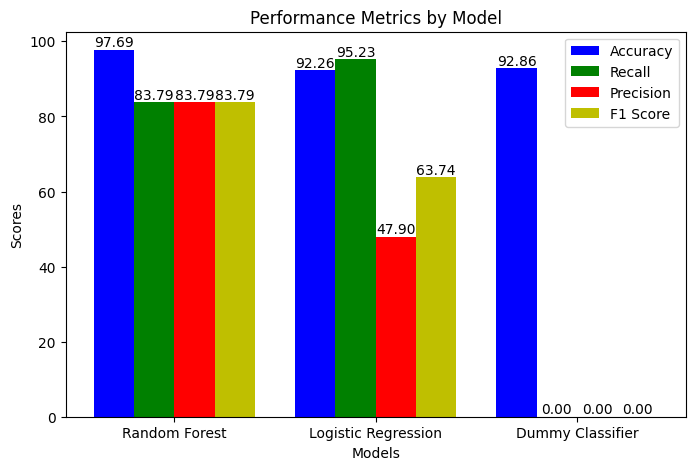

In [ ]:

# Define the models and metrics
models = ['Random Forest', 'Logistic Regression', 'Dummy Classifier']
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

# Define the scores for each metric and model
accuracy_scores = [accuracy_rf, accuracy_log, accuracy_dc]
recall_scores = [recall_rf, recall_log, recall_dc]
precision_scores = [precision_rf, precision_log, precision_dc]
f1_scores = [f1_rf, f1_log, f1_dc]

# Set the positions and width for the bars
ind = np.arange(len(models))
width = 0.2

# Create the bar plots
plt.figure(figsize=(8, 5))

bars = [
    plt.bar(ind, accuracy_scores, width, label='Accuracy', color='b'),
    plt.bar(ind + width, recall_scores, width, label='Recall', color='g'),
    plt.bar(ind + 2*width, precision_scores, width, label='Precision', color='r'),
    plt.bar(ind + 3*width, f1_scores, width, label='F1 Score', color='y')
]

# Add data labels
for bar in bars:
    for b in bar:
        plt.text(b.get_x() + b.get_width() / 2, b.get_height() + 0.05,
                 f'{b.get_height():.2f}', ha='center', va='bottom')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Performance Metrics by Model')
plt.xticks(ind + width*1.5, models)
plt.legend()

# Show the plot
plt.show()


Having looked at the outputs of each of the 3 models individually, it is clear that while the DC is a good baseline model, for the purpose of this evaluation, it should not be looked at any further as it is thoroughly outclassed by Both Logistic Regression and Random Forest.

While Random Forest is clearly the most suitable model for this scenario, it does come with its own set of limitations. The model is susceptible to overfitting, an undesirable behaviour in machine learning that can be detrimental when applied to the testing dataset or deployed in a real-world setting. Overfitting occurs when the model learns the training data too well, resulting in inaccurate predictions on unseen data (Ellis, 2021) To counteract this, various techniques such as fine-tuning hyperparameters can be employed for improved performance, or utilising ensemble methods by combining multiple models.

With by far the highest F1 score, the Random Forest model should be implement out of the 3 looked at in this however, in the real word techniques like bagging and boosting, used by models like the Gradient Boosting Machine, enhance the overall effectiveness and robustness of the model (Krishna and Praveenchandar, 2022). Additionally, deep learning architectures like Artificial Neural Networks and Support Vector Machines are employed as viable alternatives. These models serve in both classification and regression tasks, with ANNs demonstrating proficiency in uncovering intricate patterns within extensive, intricate datasets, and their versatility extends to applications in both supervised and unsupervised learning contexts (Gurney, 2018).

My ultimate recommendation is to further explore model such as those mentioned above while using the RF model results as the new base line for all other models to be compared against. This will quickly inform us on if a model is worth further exploring.


# References

Atkinson, A. C., 2020. The Box-Cox Transformation: Review and extensions. pp. 239-255.

Chorev, S., 2021. A Practical Guide to Data Cleaning. [Online]
Available at: https://shorturl.at/iBMS2
[Accessed 08 09 2023].

Diemert, E., Betlei, A., Renaudin, C. & Amini, M.-R., 2018. A Large Scale Benchmark for Uplift Modeling. HAL Open Science.

Dong, G. & Liu, H., 2018. Feature Engineering for Machine Learning and Data Analytics. s.l.:CRC press, 2018.

Ellis, C., 2021. Random forest overfitting. [Online]
Available at: https://shorturl.at/bcLRT
[Accessed 08 09 2023].

Gurney, K. (2018). An Introduction to Neural Networks. CRC Press.

Krishna, M.Vamsi. and Praveenchandar, J. (2022). Comparative Analysis of Credit Card Fraud Detection using Logistic regression with Random Forest towards an Increase in Accuracy of Prediction.

LAVALLE, A., MATÉ, A., TRUJILLO, J. & TERUEL, M. A., 2023. A Data Analytics Methodology to Visually Analyze the Impact of Bias and Rebalancing. IEEE Access, Volume 11, pp. 56691-56702.

Lukas Budach, M. F. N. I. A. N. N. N. H. P. F. N. H. H., 2022. The Effects of Data Quality on Machine Learning Performance. arXiv preprint, Volume 2207, pp. 1-40.

Mohamed, M. M. & Schuller, B. W., n.d. Normalise for Fairness: A Simple Normalisation Technique for Fairness in Regression Machine Learning Problem. arXiv preprint, Volume 2202.

Nithya Sambasivan, S. K. H. H. D. A. P. P. L. A., 2021. “Everyone wants to do the model work, not the data work”: Data Cascades in High-Stakes AI. Conference on Human Factors in Computing Systems, pp. 1-15.

Post Office, 2023. How to apply for a credit card. [Online]
Available at: https://shorturl.at/elFW1
[Accessed 08 09 2023].

Rigatti, S.J., 2017. Random forest. Journal of Insurance Medicine, 47(1), pp.31-39.

Sperandei, S., 2013. Understanding logistic regression analysis. Lessons in biostatistics, pp. 12-18.

Thapa, N., 2020. Credit Card Fraud Detection: Choosing the Right Metrics for Model. [Online]
Available at: https://shorturl.at/eOX01
[Accessed 08 09 2023].

